In [1440]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

In [1441]:
root = Path(r"C:\Users\Jiang\Documents\Mie_Py\Mie_Postprocessing_Py\BC20241003_HZ_Nozzle1")

subdirs = [p for p in root.rglob("*") if p.is_dir()]


In [ ]:

folder = Path(r"C:\Users\Jiang\Documents\Mie_Py\Mie_Postprocessing_Py\BC20241003_HZ_Nozzle1\T9")

or_ = 376  # or_ = 90mm
ir_ = 11
diff_threshold = 2 # px

mm_per_px_scale = 90.0/or_

print(f"mm per pixel: {mm_per_px_scale}")

In [1444]:
# discover all CSV files in this folder
csv_files = sorted(folder.glob("*.csv"))
print(f"Found {len(csv_files)} CSV files in {folder}")

if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {folder}")


Found 5 CSV files in C:\Users\Jiang\Documents\Mie_Py\Mie_Postprocessing_Py\BC20241003_HZ_Nozzle1\T9


In [1445]:
# keep one sample dataframe for preview/debug cells below
df = pd.read_csv(csv_files[0])
print(f"Sample file for preview cells: {csv_files[0].name}")


Sample file for preview cells: 1.csv


In [1447]:
tilt_ang = (180.0-df["umbrella_angle_deg"][0].item())/2.0

umbrella_angle_correction = 1.0/np.cos(tilt_ang * (np.pi / 180.0))

pen_correction = mm_per_px_scale * umbrella_angle_correction

print(f"Penetration multiplier: {pen_correction}")


Penetration multiplier: 0.25472340298625556


In [1448]:
df.columns

Index(['frame_idx', 'plumes', 'diameter_mm', 'umbrella_angle_deg', 'fps',
       'chamber_pressure_bar', 'injection_duration_us',
       'injection_pressure_bar', 'penetration_highpass_bw_plume_0',
       'penetration_highpass_bw_plume_1', 'penetration_highpass_bw_plume_2',
       'penetration_highpass_bw_plume_3', 'penetration_highpass_bw_plume_4',
       'penetration_highpass_bw_plume_5', 'penetration_highpass_bw_plume_6',
       'penetration_highpass_bw_plume_7', 'penetration_highpass_bw_plume_8',
       'penetration_highpass_bw_plume_9'],
      dtype='object')

In [1449]:
df["injection_duration_us"][0].item() * 1e-3

0.779

In [1450]:
fps = df["fps"][0].item()

frame_idx = np.asarray(df["frame_idx"])

time_s = frame_idx * 1.0 / fps

time_ms = time_s * 1e3

In [1451]:
frame_idx.max() 

np.int64(79)

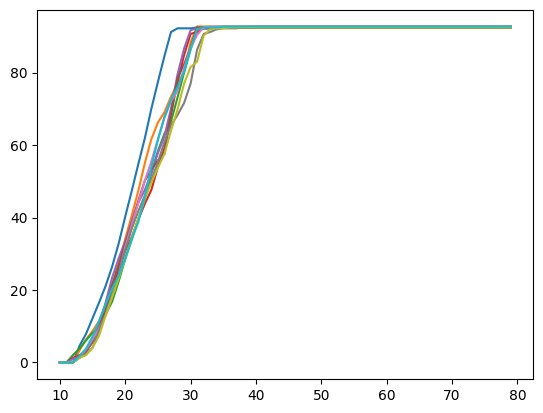

In [1452]:
for i in range(10):
    plt.plot(pen_correction*df[f'penetration_highpass_bw_plume_{i}'][10:])

In [1453]:
def penetration_cleaning(arr, scaling_factor, diff_threshold=1.0, hd_upper_lim=15):
    arr = np.asarray(arr, dtype=float).copy()
    penetration_delay = 0

    if arr.size <= 1:
        return arr * scaling_factor, penetration_delay

    scan_limit = min(hd_upper_lim, arr.size - 1)
    for f in range(scan_limit):
        if arr[f + 1] == 0 or np.isnan(arr[f + 1]):
            penetration_delay += 1
            arr[f] = np.nan

    if penetration_delay > 0:
        # Shift left without wraparound; fill tail with NaN.
        arr_shifted = np.full_like(arr, np.nan, dtype=float)
        if penetration_delay < arr.size:
            arr_shifted[:-penetration_delay] = arr[penetration_delay:]
        arr = arr_shifted

    arr_diff = np.diff(arr)
    valid_idx = np.where(arr_diff < diff_threshold)[0]
    if valid_idx.size > 0:
        arr = arr[:valid_idx[0].item()]

    arr *= scaling_factor

    return arr, penetration_delay


In [1454]:


number_of_plumes = df["plumes"][0]

cleaned_series = np.full((number_of_plumes, frame_idx.max()+1), np.nan, dtype=float)
delays = np.zeros(number_of_plumes, dtype=float)

for i in range(number_of_plumes):

    arr = df[f'penetration_highpass_bw_plume_{i}'].copy()

    cleaned_serie, delay = penetration_cleaning(arr, pen_correction, diff_threshold=diff_threshold)

    delays[i] = delay
    
    cleaned_series[i, :len(cleaned_serie)] = cleaned_serie

    # remaining tail is already NaN

# cleaned_series = np.roll(cleaned_series, -np.median(delays), axis=0)

In [1455]:
np.roll([[1,1],[0,0]], 1)

array([[0, 1],
       [1, 0]])

In [1456]:
inj_dur_s = df["injection_duration_us"][0]*1e-6
inj_dur_ms = inj_dur_s*1e3


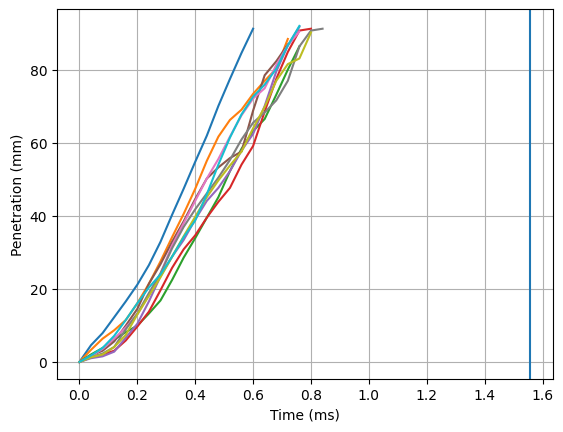

In [1457]:
plt.plot(time_ms, cleaned_series.T)
# plt.axvline(inj_dur_ms)
plt.axvline(2*inj_dur_ms)
plt.ylabel("Penetration (mm)")
plt.xlabel("Time (ms)")
plt.grid()

In [1458]:
frame_idx_at_2ti =  round(2*inj_dur_s * fps)

not_saturated = cleaned_series[:, frame_idx_at_2ti] < np.nanmax(cleaned_series, axis=1)

In [1459]:
not_saturated

array([False, False, False, False, False, False, False, False, False,
       False])

In [1460]:
df.columns

Index(['frame_idx', 'plumes', 'diameter_mm', 'umbrella_angle_deg', 'fps',
       'chamber_pressure_bar', 'injection_duration_us',
       'injection_pressure_bar', 'penetration_highpass_bw_plume_0',
       'penetration_highpass_bw_plume_1', 'penetration_highpass_bw_plume_2',
       'penetration_highpass_bw_plume_3', 'penetration_highpass_bw_plume_4',
       'penetration_highpass_bw_plume_5', 'penetration_highpass_bw_plume_6',
       'penetration_highpass_bw_plume_7', 'penetration_highpass_bw_plume_8',
       'penetration_highpass_bw_plume_9'],
      dtype='object')

$$

S_{tip} = K_p (\Delta P / \rho_a)^{1/4} (d_n)^{1/2} (t)^{0.5}, 0 < t < 2t_i
$$

$$
S_{tip} = \sqrt{2} K_p * (\Delta P / \rho_a)^{1/4} t_i^{0.25} (t-t_i)^{0.25}, t>2t_i
$$

In [1461]:
import numpy as np

# 物理常数
R_air = 287.05 
T_amb = 293.0   # 论文中实验环境温度 [cite: 537]
rho_fuel = 818.0 # 论文中的燃油密度 [cite: 529]

# 实验输入
ti = 0.779e-3   # 实际喷射持续时间 (s)
inj_p_bar = 2000.0
chamber_p_bar = 5.0
dn = 0.000384   # 喷嘴直径 (m)

# 1. 单位统一换算为 SI 标准单位
delta_P = (inj_p_bar - chamber_p_bar) * 1e5 # Pascal [cite: 284]
rho_a = (chamber_p_bar * 1e5) / (R_air * T_amb) # 计算真实密度 

# 2. 计算破碎时间 tb [cite: 315]
K_bt = 28.65 # Hiroyasu 常数 
tb = K_bt * (rho_fuel * dn) / (rho_a * delta_P)**0.5

# 3. 穿深计算
K_v = 0.39   # 线性段常数 
K_p = 2.95  # 平方根段常数 

time_plot = np.linspace(0, 5e-3, 100)
pen_theory = np.zeros_like(time_plot)

for idx, t in enumerate(time_plot):
    if t <= tb:
        # 阶段 0: 线性阶段 
        pen_theory[idx] =   K_v * (2 * delta_P / rho_fuel)**0.5 * t
        # pass
    elif t <= 2 * ti:
        # 阶段 1 & 2: 平方根阶段 [cite: 281]
        pen_theory[idx] =  K_p * (delta_P / rho_a)**0.25 * dn**0.5 * t**0.5
        # pass
    else:
        # 阶段 3: 减速阶段 (四次方根) [cite: 300]
        # 这里的连续性修正项已经在公式(5)中给出
        pen_theory[idx] =  np.sqrt(2) * K_p * (delta_P / rho_a)**0.25 * dn**0.5 * ti**0.25 * (t - ti)**0.25

# 注意：结果单位是米 (m)，画图时可能需要乘以 1000 转为 mm

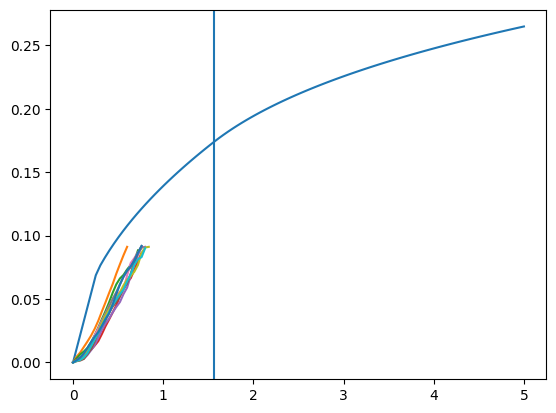

In [1462]:
plt.plot(time_plot*1e3, pen_theory)
plt.plot(time_ms, cleaned_series.T/1e3)

plt.axvline(2*ti*1e3)

In [1463]:
import numpy as np
from scipy.special import expit  # expit(x) = 1 / (1 + exp(-x))

# If you used a lower bound on tb before, keep it here
min_ti = 0.0  # change if you want a strictly positive minimum break time


def spray_penetration_model_sigmoid(params, t, ti):
    """
    params (log-space): [log_k_sqrt, log_k_quarter, log_tb, log_s]
        - k_sqrt    : effective sqrt-region gain
        - k_quarter : effective quarter-root gain
        - t0        : time of injection (with lower bound min_t0)
        - s         : transition softness of the sigmoid

    t: array-like or float (time)
    """
    log_k_sqrt, log_k_quarter, log_tb, log_s = params

    k_sqrt = np.exp(log_k_sqrt)
    k_quarter = np.exp(log_k_quarter)
    t0 = np.exp(log_tb) + min_ti
    s = np.exp(log_s)

    # numerical guard
    t = np.clip(t, 1e-9, None)

    # Sqrt and quarter-root asymptotes
    sqrt_segment = k_sqrt * np.sqrt(t)
    
    quarter_root_segment = k_quarter * np.power(t, 0.25)

    # Sigmoid weight for the quarter-root side; (1 - w) weights the sqrt side
    w = expit((t - t0) / s)

    return (1.0 - w) * sqrt_segment + w * quarter_root_segment

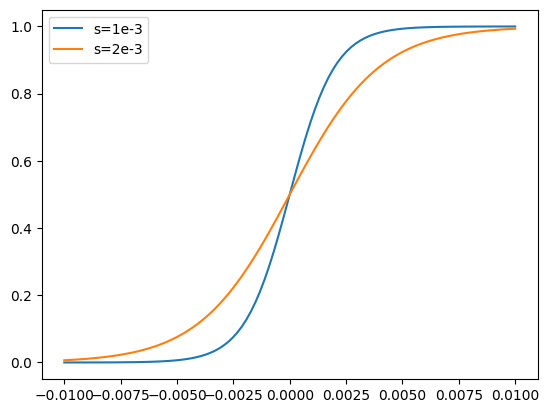

In [1464]:
plt.plot(np.linspace(-1e-2, 1e-2, 100), expit(np.linspace(-1e-2, 1e-2, 100)/1e-3), label="s=1e-3")

plt.plot(np.linspace(-1e-2, 1e-2, 100), expit(np.linspace(-1e-2, 1e-2, 100)/2e-3), label="s=2e-3")

plt.legend()

In [1465]:
from scipy.optimize import least_squares

init = {
    "k_sqrt": 1.0,
    "k_quarter": 1.0,
    "t0": 2*inj_dur_s,
    "s": 1.0,
}
x0 = np.log([init["k_sqrt"], init["k_quarter"], init["t0"], init["s"]])


def fit_sigmoid(t, ti, y, return_arrays=False):
    

    valid = np.isfinite(t) & np.isfinite(y) 
    if valid.sum() < 4:
        result = {
            "log_params": np.full(4, np.nan),
            "k_sqrt": np.nan,
            "k_quarter": np.nan,
            "t0": np.nan,
            "s": np.nan,
            "cost": np.inf,
            "success": False,
            "n": 0,
        }
        if return_arrays:
            result["t"] = t
            result["y"] = y
            
        return result

    def residuals(params):
        t_fit = t[valid]
        y_fit = y[valid]

        y_hat = spray_penetration_model_sigmoid(params, t_fit, ti)
        r = y_hat - y_fit
        if not np.all(np.isfinite(r)):
            return np.full_like(y_fit, 1e6, dtype=float)
        return r

    res = least_squares(residuals, x0, method="trf", loss="huber", f_scale=1.0)

    log_k_sqrt, log_k_quarter, log_ti, log_s = res.x
    result = {
        "log_params": res.x,
        "k_sqrt": float(np.exp(log_k_sqrt)),
        "k_quarter": float(np.exp(log_k_quarter)),
        "t0": float(np.exp(log_ti) + min_ti),
        "s": float(np.exp(log_s)),
        "cost": float(res.cost),
        "success": bool(res.success),
        "n": int(valid.sum()),
    }

    if return_arrays:
        result["t"] = t
        result["y"] = y

    return result

In [1466]:
rows = []
diff_threshold = 2
plot_fits = False

t_s_plot = np.linspace(0, 5e-3, 100)


def prepare_cleaned_series(df_file, diff_threshold=2):
    number_of_plumes = int(df_file["plumes"].iloc[0])
    fps = float(df_file["fps"].iloc[0])
    frame_idx = np.asarray(df_file["frame_idx"]).astype(int)

    time_s = frame_idx / fps
    time_ms = time_s * 1e3

    tilt_ang = (180.0 - float(df_file["umbrella_angle_deg"].iloc[0])) / 2.0
    umbrella_angle_correction = 1.0 / np.cos(np.deg2rad(tilt_ang))
    pen_correction = mm_per_px_scale * umbrella_angle_correction

    cleaned_series = np.full((number_of_plumes, int(frame_idx.max()) + 1), np.nan)
    delays = np.zeros(number_of_plumes)

    for plume_idx in range(number_of_plumes):
        col = f"penetration_highpass_bw_plume_{plume_idx}"
        if col not in df_file.columns:
            continue

        arr = np.asarray(df_file[col], dtype=float).copy()
        cleaned_serie, delay = penetration_cleaning(
            arr, pen_correction, diff_threshold=diff_threshold
        )

        delays[plume_idx] = delay
        n = min(len(cleaned_serie), cleaned_series.shape[1])
        cleaned_series[plume_idx, :n] = cleaned_serie[:n]

    return time_s, time_ms, cleaned_series, delays


if plot_fits:
    plt.figure(figsize=(8, 5))

for file_path in csv_files:
    df_file = pd.read_csv(file_path)
    time_s, time_ms, cleaned_series, delays = prepare_cleaned_series(
        df_file, diff_threshold=diff_threshold
    )

    number_of_plumes = cleaned_series.shape[0]

    for plume_idx in range(number_of_plumes):
        example_series = cleaned_series[plume_idx]
        example_fit = fit_sigmoid(time_s, inj_dur_s, example_series)

        log_k_sqrt, log_k_quarter, log_tb, log_s = example_fit["log_params"]

        valid = np.isfinite(time_s) & np.isfinite(example_series)
        if np.any(valid):
            y_true = example_series[valid]
            y_hat = spray_penetration_model_sigmoid(
                [log_k_sqrt, log_k_quarter, log_tb, log_s], time_s[valid], inj_dur_s
            )
            rmse = float(np.sqrt(np.mean((y_hat - y_true) ** 2)))
            ss_res = float(np.sum((y_true - y_hat) ** 2))
            ss_tot = float(np.sum((y_true - np.mean(y_true)) ** 2))
            r2 = float(1.0 - ss_res / ss_tot) if ss_tot > 0 else np.nan
        else:
            rmse = np.nan
            r2 = np.nan

        rows.append({
            "file_path": str(Path(file_path).resolve()),
            "file_name": file_path.name,
            "file_stem": file_path.stem,
            "plume_idx": plume_idx,
            "delay_frames": delays[plume_idx],
            "k_sqrt": example_fit["k_sqrt"],
            "k_quarter": example_fit["k_quarter"],
            "t0": example_fit["t0"],
            "s": example_fit["s"],
            "cost": example_fit["cost"],
            "success": example_fit["success"],
            "n": example_fit["n"],
            "rmse": rmse,
            "r2": r2,
            "log_k_sqrt": log_k_sqrt,
            "log_k_quarter": log_k_quarter,
            "log_t0": log_tb,
            "log_s": log_s,
        })

        if plot_fits:
            ti = example_fit["t0"]
            plt.axvline(ti * 1e3, color="gray", alpha=0.05)
            plt.plot(time_ms, example_series, alpha=0.15)
            plt.plot(
                1e3 * t_s_plot,
                spray_penetration_model_sigmoid(
                    [log_k_sqrt, log_k_quarter, log_tb, log_s], t_s_plot, inj_dur_s
                ),
                linestyle="--",
                alpha=0.15,
            )

results_df = pd.DataFrame(rows)
results_df = results_df.replace([np.inf, -np.inf], np.nan)
print(f"Processed {len(csv_files)} files -> {len(results_df)} plume fits")

if plot_fits:
    plt.xlim(0, 5)
    plt.ylim(0, 150)


Processed 5 files -> 50 plume fits


In [1467]:
results_df

,file_path,file_name,file_stem,plume_idx,delay_frames,k_sqrt,k_quarter,t0,s,cost,success,n,rmse,r2,log_k_sqrt,log_k_quarter,log_t0,log_s
0,C:\Users\Jiang\Documents\Mie_Py\Mie_Postproces...,1.csv,1,0,12.0,7.495664e-07,714.433632,0.000374,0.000155,2.170302,True,16,0.527713,0.999669,-14.103771,6.571490,-7.892500,-8.771538
1,C:\Users\Jiang\Documents\Mie_Py\Mie_Postproces...,1.csv,1,1,12.0,1.701751e+01,523.746069,0.000328,0.000121,8.180864,True,19,1.443329,0.997473,2.834243,6.261007,-8.021951,-9.020860
2,C:\Users\Jiang\Documents\Mie_Py\Mie_Postproces...,1.csv,1,2,11.0,2.561846e-06,571.142284,0.000457,0.000153,9.888228,True,20,1.213576,0.998078,-12.874782,6.347638,-7.690130,-8.784149
3,C:\Users\Jiang\Documents\Mie_Py\Mie_Postproces...,1.csv,1,3,11.0,1.984429e-06,649.073413,0.000509,0.000172,38.598593,True,21,2.638187,0.992464,-13.130179,6.475546,-7.583306,-8.666382
4,C:\Users\Jiang\Documents\Mie_Py\Mie_Postproces...,1.csv,1,4,11.0,2.451819e-05,713.084526,0.000523,0.000196,43.353986,True,20,3.095753,0.988867,-10.616095,6.569600,-7.556134,-8.539376
5,C:\Users\Jiang\Documents\Mie_Py\Mie_Postproces...,1.csv,1,5,12.0,1.485296e-05,576.835668,0.000379,0.000151,38.956818,True,19,3.554250,0.983830,-11.117312,6.357557,-7.878442,-8.797437
6,C:\Users\Jiang\Documents\Mie_Py\Mie_Postproces...,1.csv,1,6,12.0,4.881671e-06,552.881451,0.000375,0.000133,16.394782,True,20,1.526085,0.997440,-12.230023,6.315144,-7.888948,-8.926929
7,C:\Users\Jiang\Documents\Mie_Py\Mie_Postproces...,1.csv,1,7,12.0,1.569587e-05,582.723043,0.000422,0.000177,42.272290,True,22,2.846061,0.991111,-11.062113,6.367712,-7.769562,-8.636797
8,C:\Users\Jiang\Documents\Mie_Py\Mie_Postproces...,1.csv,1,8,12.0,1.917010e-05,566.096199,0.000416,0.000164,31.642421,True,21,2.355635,0.993554,-10.862159,6.338764,-7.785956,-8.718112
9,C:\Users\Jiang\Documents\Mie_Py\Mie_Postproces...,1.csv,1,9,12.0,6.606400e-07,609.112369,0.000418,0.000159,14.477235,True,20,1.357006,0.997945,-14.230057,6.412003,-7.781137,-8.747147


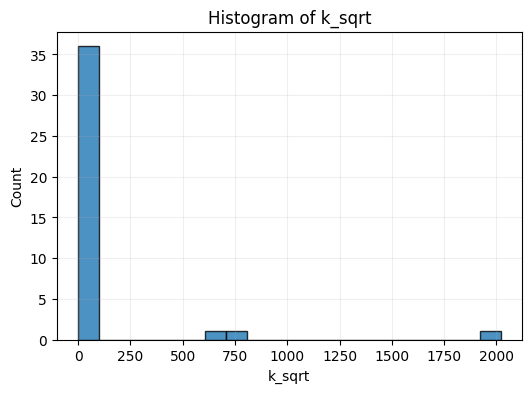

In [1468]:
plt.figure(figsize=(6, 4))
plt.hist(results_df.loc[np.isfinite(results_df["k_sqrt"]), "k_sqrt"], bins=20, edgecolor="black", alpha=0.8)
plt.xlabel("k_sqrt")
plt.ylabel("Count")
plt.title("Histogram of k_sqrt")
plt.grid(alpha=0.2)
plt.show()


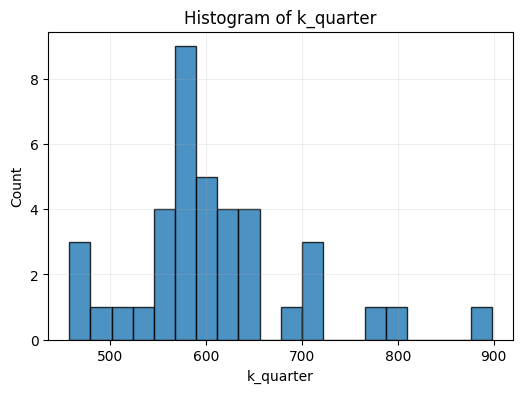

In [1469]:
plt.figure(figsize=(6, 4))
plt.hist(results_df.loc[np.isfinite(results_df["k_quarter"]), "k_quarter"], bins=20, edgecolor="black", alpha=0.8)
plt.xlabel("k_quarter")
plt.ylabel("Count")
plt.title("Histogram of k_quarter")
plt.grid(alpha=0.2)
plt.show()

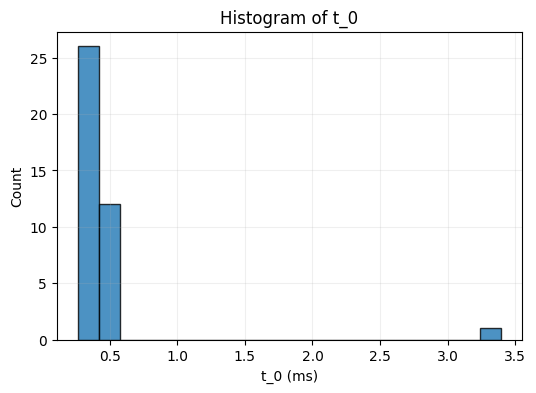

In [1470]:
plt.figure(figsize=(6, 4))
plt.hist(1e3 * results_df.loc[np.isfinite(results_df["t0"]), "t0"], bins=20, edgecolor="black", alpha=0.8)
plt.xlabel("t_0 (ms)")
plt.ylabel("Count")
plt.title("Histogram of t_0")
plt.grid(alpha=0.2)
plt.show()

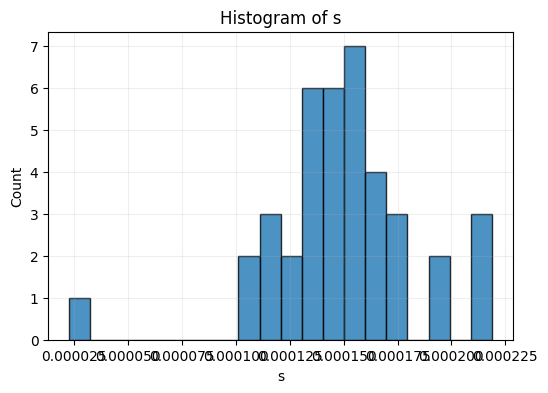

In [1471]:
plt.figure(figsize=(6, 4))
plt.hist(results_df.loc[np.isfinite(results_df["s"]), "s"], bins=20, edgecolor="black", alpha=0.8)
plt.xlabel("s")
plt.ylabel("Count")
plt.title("Histogram of s")
plt.grid(alpha=0.2)
plt.show()

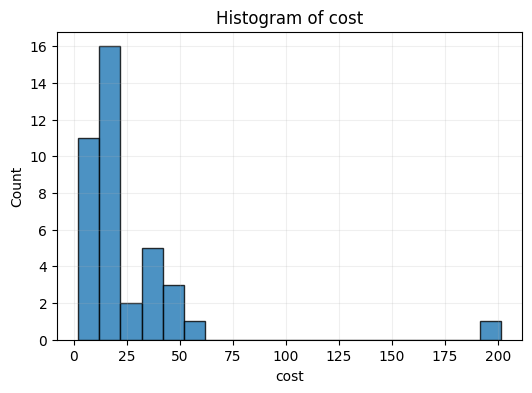

In [1472]:
plt.figure(figsize=(6, 4))
plt.hist(results_df.loc[np.isfinite(results_df["cost"]), "cost"], bins=20, edgecolor="black", alpha=0.8)
plt.xlabel("cost")
plt.ylabel("Count")
plt.title("Histogram of cost")
plt.grid(alpha=0.2)
plt.show()

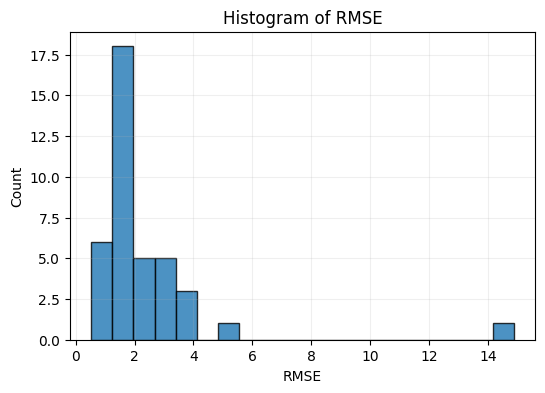

In [1473]:
plt.figure(figsize=(6, 4))
plt.hist(results_df.loc[np.isfinite(results_df["rmse"]), "rmse"], bins=20, edgecolor="black", alpha=0.8)
plt.xlabel("RMSE")
plt.ylabel("Count")
plt.title("Histogram of RMSE")
plt.grid(alpha=0.2)
plt.show()

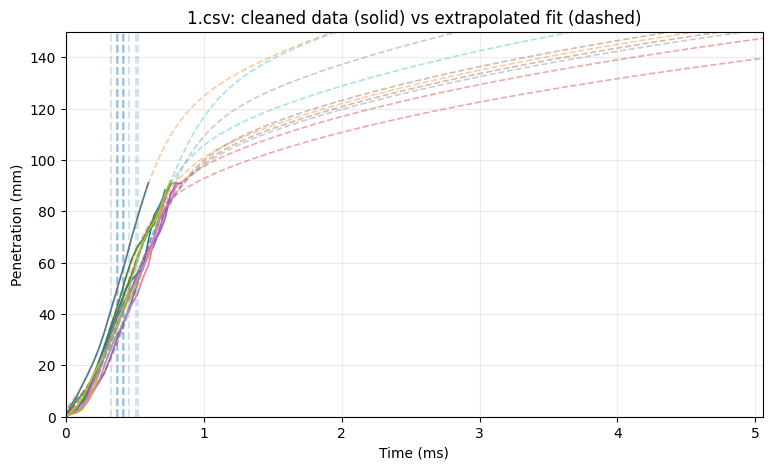

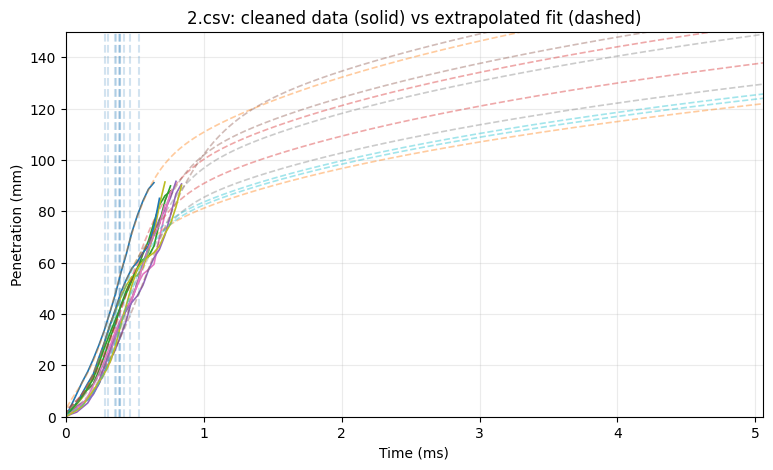

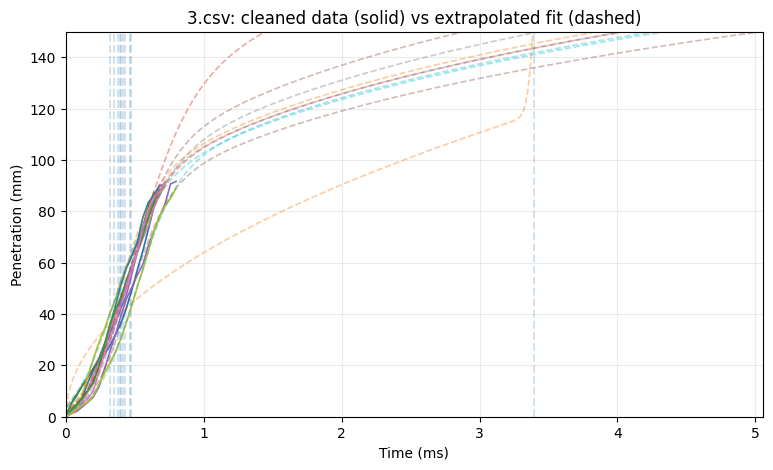

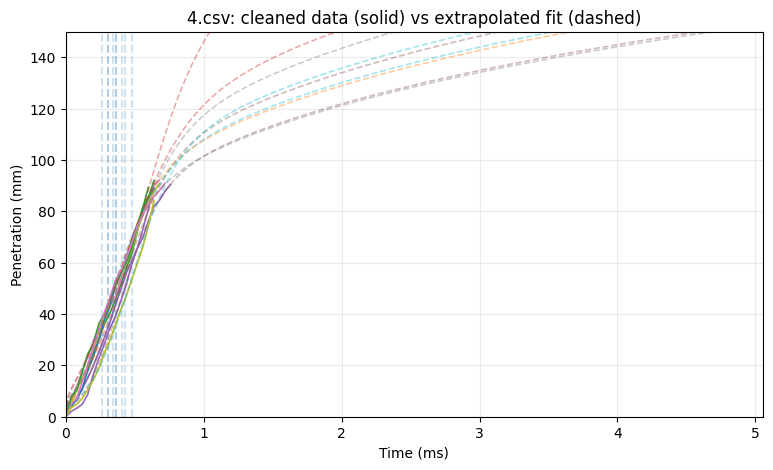

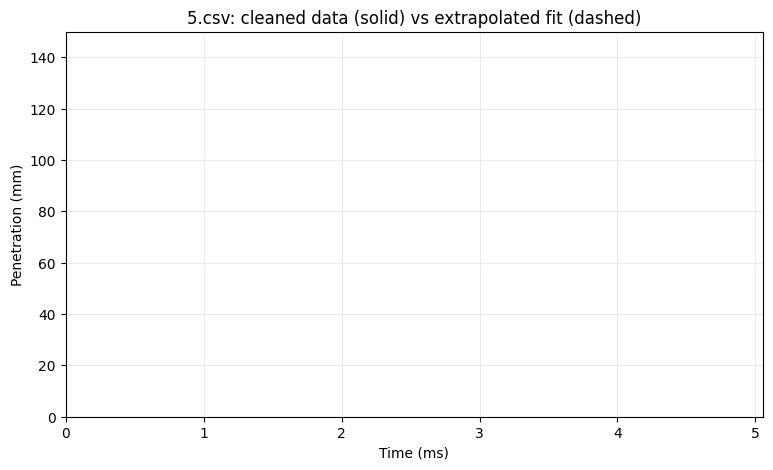

In [1474]:
# Validation plots: one figure per file (cleaned raw traces vs extrapolated fitted curves)
extrapolation_factor = 1.6  # 1.0 = no extrapolation, >1 extends time axis
num_curve_points = 300

for file_path in csv_files:
    df_file = pd.read_csv(file_path)
    time_s, time_ms, cleaned_series, _ = prepare_cleaned_series(df_file, diff_threshold=2)

    t_end = float(np.nanmax(time_s) * extrapolation_factor)
    t_extrap_s = np.linspace(0.0, t_end, num_curve_points)

    plt.figure(figsize=(9, 5))

    file_rows = results_df[results_df["file_name"] == file_path.name]

    for _, fit_row in file_rows.iterrows():
        plume_idx = int(fit_row["plume_idx"])
        if plume_idx >= cleaned_series.shape[0]:
            continue

        raw_series = cleaned_series[plume_idx]
        plt.plot(time_ms, raw_series, alpha=1, linewidth=1.2)

        log_params = [
            fit_row["log_k_sqrt"],
            fit_row["log_k_quarter"],
            fit_row["log_t0"],
            fit_row["log_s"],
        ]
        y_extrap = spray_penetration_model_sigmoid(log_params, t_extrap_s, inj_dur_s)
        plt.plot(1e3 * t_extrap_s, y_extrap, linestyle="--", alpha=0.4, linewidth=1.2)
        plt.axvline(1e3*fit_row["t0"], linestyle="--", alpha=0.2)

    # plt.axvline(np.nanmax(time_ms), color="k", linestyle=":", alpha=0.4)
    
    plt.title(f"{file_path.name}: cleaned data (solid) vs extrapolated fit (dashed)")
    plt.xlabel("Time (ms)")
    plt.ylabel("Penetration (mm)")
    plt.grid(alpha=0.25)
    plt.xlim(0, 1e3 * t_end)
    plt.ylim(bottom=0)
    plt.ylim(0, 150)
    plt.show()
    


In [1475]:
results_df

,file_path,file_name,file_stem,plume_idx,delay_frames,k_sqrt,k_quarter,t0,s,cost,success,n,rmse,r2,log_k_sqrt,log_k_quarter,log_t0,log_s
0,C:\Users\Jiang\Documents\Mie_Py\Mie_Postproces...,1.csv,1,0,12.0,7.495664e-07,714.433632,0.000374,0.000155,2.170302,True,16,0.527713,0.999669,-14.103771,6.571490,-7.892500,-8.771538
1,C:\Users\Jiang\Documents\Mie_Py\Mie_Postproces...,1.csv,1,1,12.0,1.701751e+01,523.746069,0.000328,0.000121,8.180864,True,19,1.443329,0.997473,2.834243,6.261007,-8.021951,-9.020860
2,C:\Users\Jiang\Documents\Mie_Py\Mie_Postproces...,1.csv,1,2,11.0,2.561846e-06,571.142284,0.000457,0.000153,9.888228,True,20,1.213576,0.998078,-12.874782,6.347638,-7.690130,-8.784149
3,C:\Users\Jiang\Documents\Mie_Py\Mie_Postproces...,1.csv,1,3,11.0,1.984429e-06,649.073413,0.000509,0.000172,38.598593,True,21,2.638187,0.992464,-13.130179,6.475546,-7.583306,-8.666382
4,C:\Users\Jiang\Documents\Mie_Py\Mie_Postproces...,1.csv,1,4,11.0,2.451819e-05,713.084526,0.000523,0.000196,43.353986,True,20,3.095753,0.988867,-10.616095,6.569600,-7.556134,-8.539376
5,C:\Users\Jiang\Documents\Mie_Py\Mie_Postproces...,1.csv,1,5,12.0,1.485296e-05,576.835668,0.000379,0.000151,38.956818,True,19,3.554250,0.983830,-11.117312,6.357557,-7.878442,-8.797437
6,C:\Users\Jiang\Documents\Mie_Py\Mie_Postproces...,1.csv,1,6,12.0,4.881671e-06,552.881451,0.000375,0.000133,16.394782,True,20,1.526085,0.997440,-12.230023,6.315144,-7.888948,-8.926929
7,C:\Users\Jiang\Documents\Mie_Py\Mie_Postproces...,1.csv,1,7,12.0,1.569587e-05,582.723043,0.000422,0.000177,42.272290,True,22,2.846061,0.991111,-11.062113,6.367712,-7.769562,-8.636797
8,C:\Users\Jiang\Documents\Mie_Py\Mie_Postproces...,1.csv,1,8,12.0,1.917010e-05,566.096199,0.000416,0.000164,31.642421,True,21,2.355635,0.993554,-10.862159,6.338764,-7.785956,-8.718112
9,C:\Users\Jiang\Documents\Mie_Py\Mie_Postproces...,1.csv,1,9,12.0,6.606400e-07,609.112369,0.000418,0.000159,14.477235,True,20,1.357006,0.997945,-14.230057,6.412003,-7.781137,-8.747147


In [1476]:
df = results_df.copy()

def robust_z(s):
    s = pd.to_numeric(s, errors="coerce")

    med = s.median()
    mad = (s-med).abs().median()

    return 0.6745 * (s-med) / mad + 1e-12

In [1477]:
# 1) hard checks
t_max = np.nanmax(time_s)  # or per-file max time
df["cost_per_point"] = 2.0 * df["cost"] / df["n"].clip(lower=1)

mask_basic = (
    df["success"].fillna(False)
    & np.isfinite(df["t0"])
    & np.isfinite(df["rmse"])
    & np.isfinite(df["cost_per_point"])
    & (df["n"] >= 10)
    & (df["t0"] > 0)
    & (df["t0"] < t_max)
    & (df["s"] > 0)
    & (df["s"] < 1e-3) # Assume less than 1ms
)


In [1478]:
# 2) robust outlier checks (group by condition if available)
group_cols = ["file_name"]  # replace/add condition cols if needed

df["z_t0"] = df.groupby(group_cols, dropna=False)["t0"].transform(robust_z)
df["z_rmse"] = df.groupby(group_cols, dropna=False)["rmse"].transform(lambda s: robust_z(np.log1p(s)))
df["z_cost"] = df.groupby(group_cols, dropna=False)["cost_per_point"].transform(lambda s: robust_z(np.log1p(s)))

mask_outlier = (
    df["z_t0"].abs().gt(3)
    | df["z_rmse"].abs().gt(3)
    | df["z_cost"].abs().gt(3)
)

c:\Users\Jiang\Documents\Mie_Py\Mie_Postprocessing_Py\.venv311\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Jiang\Documents\Mie_Py\Mie_Postprocessing_Py\.venv311\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Jiang\Documents\Mie_Py\Mie_Postprocessing_Py\.venv311\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Jiang\Documents\Mie_Py\Mie_Postprocessing_Py\.venv311\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Jiang\Documents\Mie_Py\Mie_Postprocessing_Py\.venv311\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty sli

In [1479]:
df["flag_bad_fit"] = (~mask_basic) | mask_outlier

clean_df = df.loc[~df["flag_bad_fit"]].copy()
flagged_df = df.loc[df["flag_bad_fit"]].copy()

In [1480]:
from pathlib import Path

# csv_files should be your original list of Path objects
name_to_paths = {}
for p in map(Path, csv_files):
    name_to_paths.setdefault(p.name, []).append(p)

def resolve_csv(name):
    # Accept either file name ("1.csv") or stem ("1").
    name_str = str(name)
    cands = name_to_paths.get(name_str, [])
    if len(cands) == 0:
        cands = [p for p in map(Path, csv_files) if p.stem == name_str]
    if len(cands) == 1:
        return cands[0]
    if len(cands) == 0:
        return None
    raise ValueError(f"Ambiguous file name {name}: {cands}")  # same name in multiple dirs


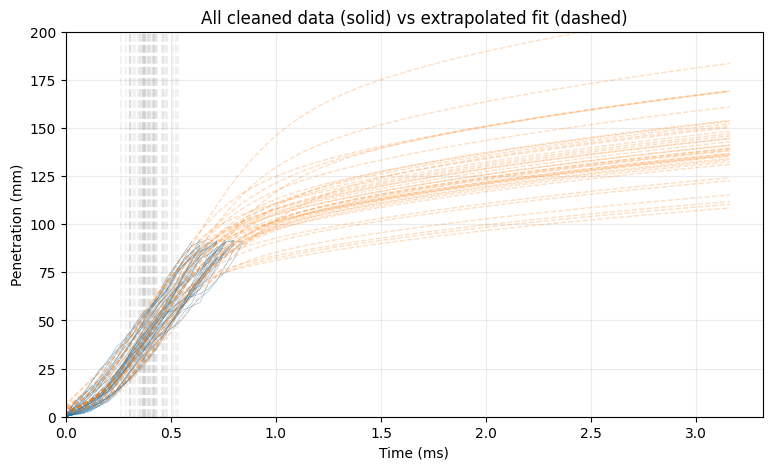

In [1481]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))

cache = {}  # cache_key -> (time_s, time_ms, cleaned_series, inj_dur_s)

for row in clean_df.itertuples(index=False):
    file_name = row.file_name
    file_path = getattr(row, "file_path", None)
    plume_idx = int(row.plume_idx)

    if file_path is not None and str(file_path) != "" and Path(file_path).exists():
        csv_path = Path(file_path)
        cache_key = str(csv_path)
    else:
        csv_path = resolve_csv(file_name)
        if csv_path is None:
            continue  # unresolved basename/stem
        cache_key = str(csv_path)

    if cache_key not in cache:
        df_file = pd.read_csv(csv_path)
        time_s, time_ms, cleaned_series, delays = prepare_cleaned_series(
            df_file, diff_threshold=diff_threshold
        )
        inj_dur_s = float(df_file["injection_duration_us"].iloc[0]) * 1e-6
        cache[cache_key] = (time_s, time_ms, cleaned_series, inj_dur_s)

    time_s, time_ms, cleaned_series, inj_dur_s = cache[cache_key]

    if plume_idx >= cleaned_series.shape[0]:
        continue

    raw_series = cleaned_series[plume_idx]
    valid = np.isfinite(time_ms) & np.isfinite(raw_series)
    plt.plot(time_ms[valid], raw_series[valid], alpha=0.68, linewidth=0.3, color="C0")

    log_params = [row.log_k_sqrt, row.log_k_quarter, row.log_t0, row.log_s]
    t_end_local = max(np.nanmax(time_s), float(row.t0) * 2.5)
    t_extrap_s = np.linspace(0, t_end_local, 250)

    y_extrap = spray_penetration_model_sigmoid(log_params, t_extrap_s, inj_dur_s)
    plt.plot(1e3 * t_extrap_s, y_extrap, linestyle="--", alpha=0.25, linewidth=1.0, color="C1")
    plt.axvline(1e3 * float(row.t0), linestyle="--", alpha=0.1, color="gray")

plt.title("All cleaned data (solid) vs extrapolated fit (dashed)")
plt.xlabel("Time (ms)")
plt.ylabel("Penetration (mm)")
plt.grid(alpha=0.25)
plt.xlim(left=0)
plt.ylim(0, 200)
plt.show()



In [1482]:
df[""]

KeyError: ''